libkmod: ERROR ../libkmod/libkmod-module.c:1668 kmod_module_new_from_loaded: could not open /proc/modules: No such file or directory
Error: could not get list of modules: No such file or directory
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


128.0

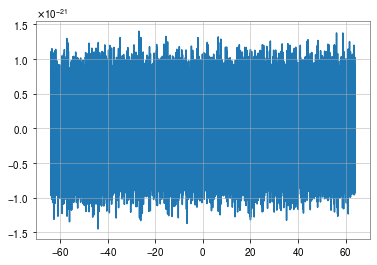

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from pycbc import frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

data = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')


data.plot()
data.duration

In [3]:
strain = highpass(data, 20.0)
strain =resample_to_delta_t(strain, 1.0/2048)

conditioned = strain.crop(2,2)


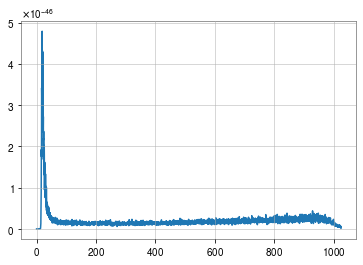

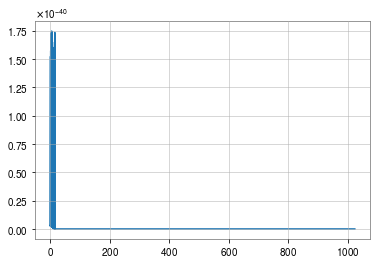

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = conditioned.psd(4)

psd = interpolate(psd, conditioned.delta_f)
plt.plot(psd.sample_frequencies, psd)
plt.show()
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)
plt.plot(psd.sample_frequencies, psd)
plt.show()

In [5]:
from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20# Let's plot the signal before and after shifting)
)

# Resize the vector to match our data
hp.resize(len(conditioned))
print(conditioned.delta_t)

0.00048828125


In [6]:
from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20# Let's plot the signal before and after shifting)
)

# Resize the vector to match our data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

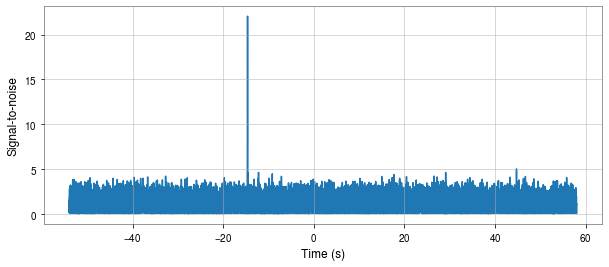

We found a signal at -14.6328125s with SNR 22.038591197432346


In [7]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [8]:
from pycbc.vetoes import power_chisq

chisq = {}

nbins = 26
chisq = power_chisq(hp, conditioned, nbins, psd, low_frequency_cutoff=20.0)
chisq = chisq.crop(8, 4)

dof = nbins * 2 - 2
chisq /= dof


In [9]:
from pycbc.events.ranking import newsnr
print(len(chisq))
print(len(snr))
# The rho-hat term above is named "newsnr" here
nsnr = newsnr(abs(snr), chisq)

peak = abs(nsnr).argmax()
nsnrp = nsnr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with NSNR {}".format(time, 
                                                    abs(nsnrp)))


229376
229376
We found a signal at -14.6328125s with NSNR 22.038591197432346


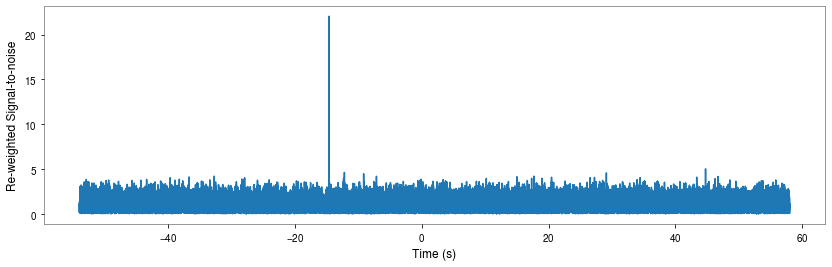

In [10]:
plt.figure(figsize=[14, 4])
plt.plot(snr.sample_times, nsnr)



plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('Re-weighted Signal-to-noise')
plt.show()

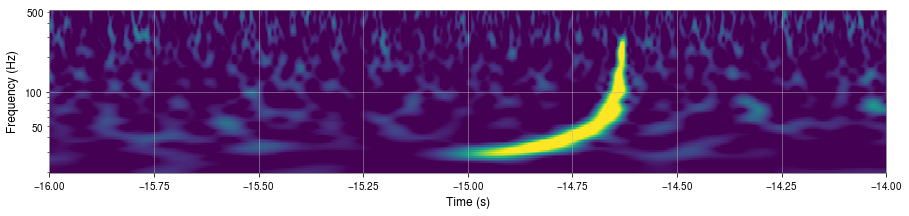

In [11]:
t, f, p = data.qtransform(.001, logfsteps=100, qrange=(10, 20), frange=(20, 512))
                                                 
plt.figure(figsize=[15, 3])
plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.xlim(-16, -14)
plt.show()